## Convolutional Neural Network for handwriting recognition

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
torch.manual_seed(0)
train_directory = "Data/"

In [2]:
class Dataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.all_files = []
        self.labels = []
        self.transform = transform

        for letter in os.listdir(train_directory):
            letter_dir = os.path.join(train_directory, letter)
            letter_files = [os.path.join(letter_dir,file) for file in os.listdir(letter_dir) if file.endswith(".jpg")]
            letter_files.sort()
            for sample in letter_files:
                label = ord(letter)%97 # Modularlly divides by 97 to label chars a-z with ints 0-25
                self.labels.append(label)
                self.all_files.append(sample)
        
        random.seed(1)
        random.shuffle(self.all_files)
        random.shuffle(self.labels)
        # Shuffle the order of the images
        # Using a 90/10 split
        if train:
            self.all_files = self.all_files[::2060]
            self.labels = self.labels[::2060]
            self.len = len(self.all_files)
        else: 
            self.all_files = self.all_files[2060::]
            self.labels = self.labels[2060::]
            self.len = len(self.all_files)
        
    def __len__(self):
        return self.len

    def __getitem__(self, id):
        image = Image.open(self.all_files[id])
        label = self.labels[id]

        if self.transform: # Apply a transform if needed
            image = self.transform(image)

        return image, label

In [3]:
class CNN(nn.Module):
    def __init__(self, out_1):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=2) # Convolution layer
        self.maxpool1=nn.MaxPool2d(kernel_size=2) # Max pooling layer
        self.fc1 = nn.Linear(79*79*159, 26) # Fully connected neural network

    def forward(self,x):
        x = self.cnn1(x)
        print("After cnn 1:", x.shape)
        x = torch.relu(x)
        x = self.maxpool1(x)
        print("After max pool 1:", x.shape)
        x = x.view(x.size(0), -1) # 1-D input
        x = self.fc1(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN(out_1=159)
model.to(device)

CNN(
  (cnn1): Conv2d(1, 159, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=992319, out_features=26, bias=True)
)

In [4]:
train_dataset = Dataset(transform=transforms.ToTensor(), train=True)
mean, mean_squared = 0.0, 0.0

for image, _ in train_dataset:
    mean += image[0].mean()
    mean_squared += torch.mean(image**2)

mean = mean/len(train_dataset)
#std = sqrt(E[X^2] - (E[X])^2)
std = (mean_squared / len(train_dataset) - mean ** 2) ** 0.5

composed = transforms.Compose([transforms.ToTensor(), transforms.Resize([160,160]), transforms.Normalize(mean, std)])
train_dataset = Dataset(transform=composed, train=True)
validation_dataset = Dataset(transform=composed, train=False)

In [35]:
n_epochs = 10
batch_size = 32
momentum = 0.9
lr=0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
validationloader = DataLoader(dataset=validation_dataset, batch_size=batch_size)

In [36]:
cost_list = []
accuracy_list = []

def train_model(n_epochs):
    correct = 0
    n_test = len(validation_dataset)
    for epoch in range(n_epochs):
        COST = 0
        for x, y in trainloader:
            x, y=x.to(device), y.to(device)
            model.train() 
            optimizer.zero_grad()
            
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.cpu().data
        cost_list.append(COST.cpu())
        correct = 0
        for x_test, y_test in validationloader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()

        accuracy = correct / n_test
        accuracy_list.append(accuracy)

In [41]:
train_model(50)

After cnn 1: torch.Size([2, 159, 159, 159])
After max pool 1: torch.Size([2, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([32, 159, 79, 79])
After cnn 1: torch.Size([4, 159, 159, 159])
After max pool 1: torch.Size([4, 159, 79, 79])
After cnn 1: torch.Size([2, 159, 159, 159])
After max pool 1: torch.Size([2, 159, 79, 79])
After cnn 1: torch.Size([32, 159, 159, 159])
After max pool 1: torch.Size([3

In [42]:
torch.cuda.empty_cache()
print(cost_list)
print(max(accuracy_list))

[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]
0.02631578947368421


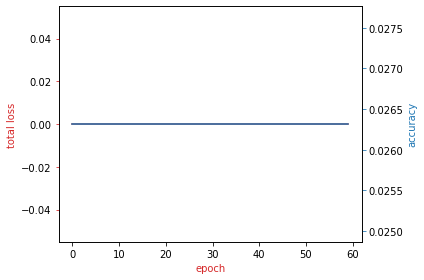

In [43]:
# Handy plotting info
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
   
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()